In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import pandas as pd
import json
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from scipy import signal
from IPython.display import clear_output
import copy
import time

linear2db = lambda x: 10*np.log10(x) 
db2linear = lambda x: np.power(10,x/10)

N_max = 2**11

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### The missions we need to do:
- [x] We want to discover a resolution for good and bad separation of the FFT.
- [x] According to the resolution generating data.
- [x] Somehow model the problem into a neural network.

##### Mission 1: We want to discover a resolution for good and bad separation of the FFT.


In [2]:
def createSignal(v = np.array([90, 100]), target_ratio = 2, f_c = 2e9, T = 100e-5, N = N_max, pad = 0, SNR = np.inf):
    
    c = 3e8                        # speed of light in m/s
    λ = c/f_c                      # wavelength of radar signal in meters
    n = np.linspace(0,N,N)

    # Compute amplitudes by the target ratio 
    A = 1
    B = A*db2linear(target_ratio)

    # Comute doppler frequency
    f_d1 = (2*v[0]/λ)
    f_d2 = (2*v[1]/λ)
    
    #Compute doppler resolution
    dopplerResolution = 1 / (T*N)
    delta_f_Doppler = (2 * abs(v[1] - v[0])) / λ
    
    #Normalize the v
    v = (v*λ)/T
    
    #Compute siganl and pad it
    s = A*np.cos(2*np.pi*f_d1*n*T) + B*np.cos(2*np.pi*f_d2*n*T)
    
    '''
    #Complex form
    s = (A/2)*np.exp(1j*2*np.pi*f_d1*n*T) + (A/2)*np.exp(-1j*2*np.pi*f_d1*n*T) + \
        (B/2)*np.exp(1j*2*np.pi*f_d2*n*T) + (B/2)*np.exp(-1j*2*np.pi*f_d2*n*T) 
    '''
    
    # Compute noise
    P_signal = np.mean(s**2)
    P_noise = P_signal /  db2linear(SNR)

    𝜖 = np.sqrt(P_noise) * np.random.randn(N)
    
    if SNR == np.inf:
        𝜖 = np.zeros(N)
    
    # Add noise to signal
    s += 𝜖
    
    return np.pad(s, pad, mode='constant', constant_values=0) , dopplerResolution, delta_f_Doppler

def SingleTargetSignal(v = 90, f_c = 2e9, T = 100e-5, N = N_max, pad = 0, SNR = np.inf):
    c = 3e8                        # speed of light in m/s
    λ = c/f_c                      # wavelength of radar signal in meters
    n = np.linspace(0,N,N)
    
    A = 1
    f_d = (2*v/λ) # Comute doppler frequency
    
    #Compute siganl and pad it
    s = A*np.cos(2*np.pi*f_d*n*T)
    
    # Compute noise
    P_signal = np.mean(s**2)
    P_noise = P_signal /  db2linear(SNR)

    𝜖 = np.sqrt(P_noise) * np.random.randn(N)
    
    if SNR == np.inf:
        𝜖 = np.zeros(N)
    
    # Add noise to signal
    s += 𝜖
    
    return np.pad(s, pad, mode='constant', constant_values=0)
    

In [3]:
def plot_signal(s, db = False, title = ""):
    
    plt.figure(figsize = (18, 3))
    plt.title(title)
    
    if db:
        plt.plot(range(len(s)), np.abs(linear2db(s+ 1e-9)), 'cyan')
    else:
        plt.plot(range(len(s)), s, 'purple')

    plt.ylabel('Amplitude')
    plt.show()
    
def fft(s, hamming = True):
    if hamming:
        return np.abs(np.fft.rfft(s*np.hamming(len(s))))
    else:
        return np.abs(np.fft.rfft(s))
    
    
def isSeparate(dopplerResolution, delta_f_Doppler, threshold):
    return (delta_f_Doppler - threshold * dopplerResolution) > 0
    
    
def plot_per_N(v = np.array([90, 100]), target_ratio = 20, f_c = 2e9, T = 100e-5, pad = 0, SNR = np.inf):
    
    for i in range(4):
        for j in range(2):
            s, resolution = createSignal(N = 2**(i*2+j+4),v = np.array([90, 100]), target_ratio = 20, f_c = 2e9, T = 100e-5, pad = 0, SNR = np.inf)
            
            f_s = fft(s)
            one_side = len(f_s)//2
            plot_signal(abs(f_s[:one_side]/one_side), db = True, title = "N^{}".format(i*2+j+4))  

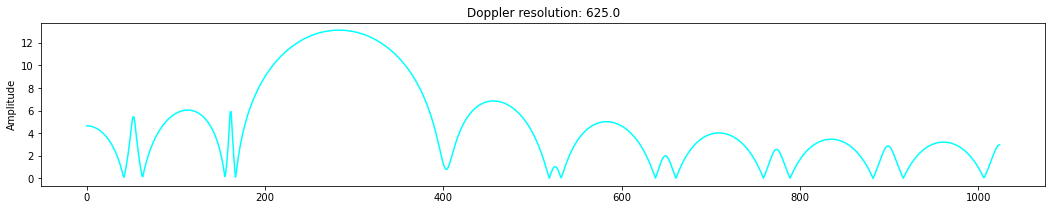

FFT did not separate targets well


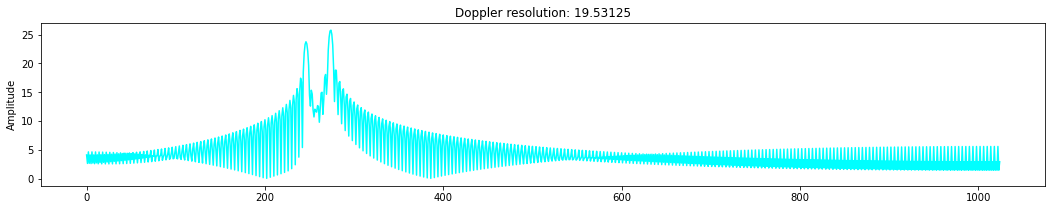

FFT separated targets well


In [4]:
s, resolution, delta_f_Doppler = createSignal(N = 2**4, T = 100e-6,pad = (N_max - 2**4)//2)
f_s = fft(s)
plot_signal(abs(f_s), db = True, title = "Doppler resolution: {}".format(resolution))
print("FFT separated targets well") if isSeparate(resolution, delta_f_Doppler, 3) else print("FFT did not separate targets well")

s, resolution, delta_f_Doppler = createSignal(N = 2**9, T = 100e-6, pad = (N_max - 2**9)//2)
f_s = fft(s)
plot_signal(abs(f_s), db = True, title = "Doppler resolution: {}".format(resolution))
print("FFT separated targets well") if isSeparate(resolution, delta_f_Doppler, 3) else print("FFT did not separate targets well")

##### Mission 2: According to the resolution generating data.

In [5]:
#Many pairs of velocity vectors

V1 = np.arange(50, 130, 3)
V2 = np.arange(50, 130, 3)

V1, V2 = np.meshgrid(V1, V2)
pairs = np.column_stack((V1.ravel(), V2.ravel()))

# Different values of PRI
T_values = np.arange(20,180,2)/1e5
N_values = 2**np.arange(6,11)

In [6]:
data = []
for pair in tqdm(pairs):
    for T_value in T_values:
        bad = []
        good = []
        for N_value in N_values:
            s, resolution, delta_f_Doppler = createSignal(v = pair, T = T_value, N =N_value, pad = (N_max - N_value)//2)
            signal = {
                "s": s,
                "resolution": resolution,
                "delta_f_Doppler": delta_f_Doppler,
                "T": T_value,
                "N": N_value,
                "V": pair
            }
            if isSeparate(resolution, delta_f_Doppler, 3):
                signal["Good"] = 1
                good.append(signal)
            else:
                signal["Good"] = 0
                bad.append(signal)
        if len(good)*len(bad) != 0:
            data += list(itertools.product(good, bad))

100%|████████████████████████████████████████████████████████████████████████████████| 729/729 [00:42<00:00, 17.31it/s]


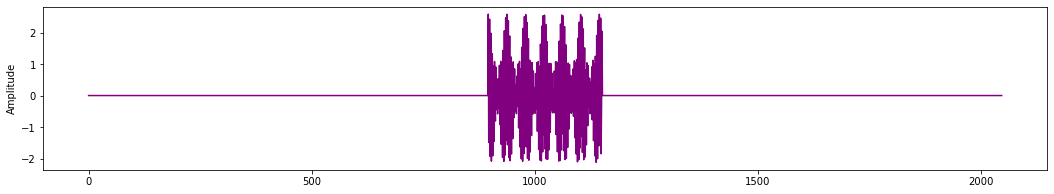

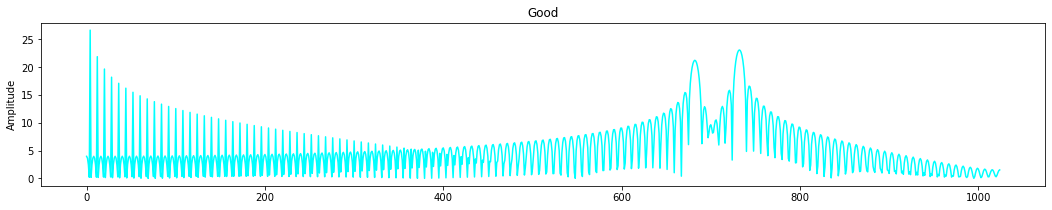

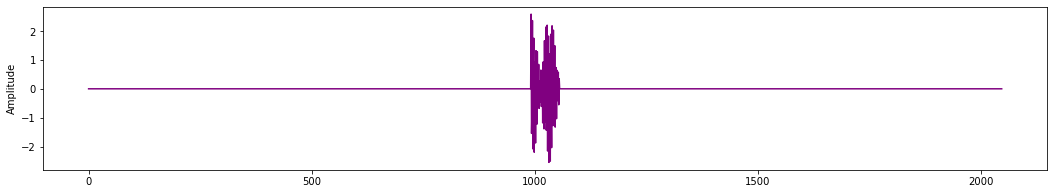

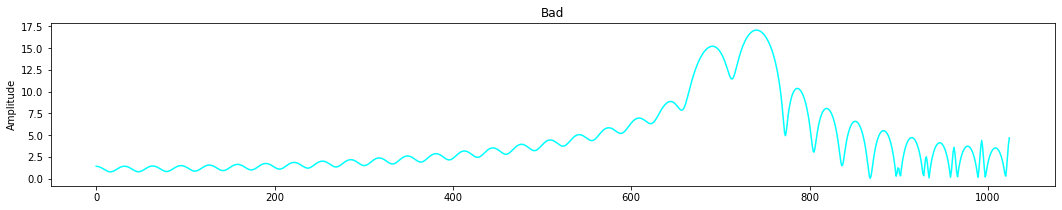

In [7]:
i = np.random.randint(len(data))

plot_signal(data[i][0]["s"])
f_s = fft(data[i][0]["s"])
plot_signal(abs(f_s), db = True, title = "Good")

##############################

plot_signal(data[i][1]["s"])
f_s = fft(data[i][1]["s"])
plot_signal(abs(f_s), db = True, title = "Bad")

In [8]:
class dataset(Dataset):
    
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(data)

    def __getitem__(self, i):
        
        x = torch.from_numpy(self.data[i][1]["s"]) # maybe we want the fft instead
        y = torch.from_numpy(fft(self.data[i][0]["s"]))
         
        return x, torch.abs(y)

dataset = dataset(data)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

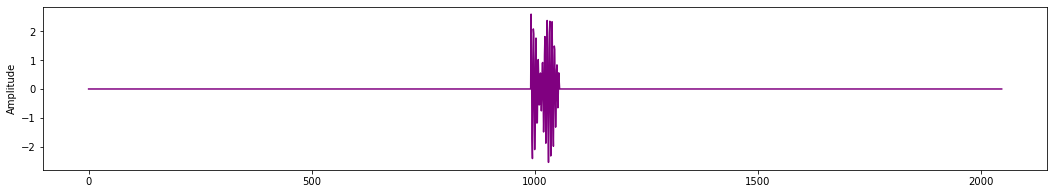

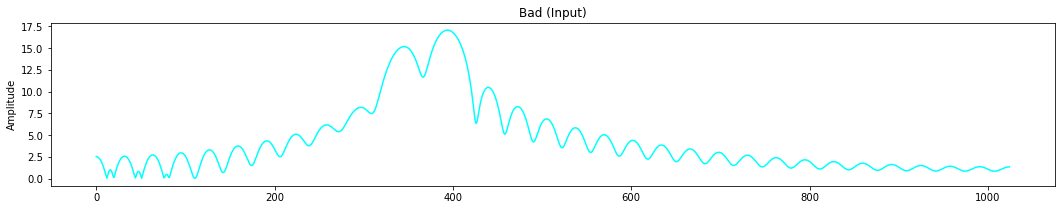

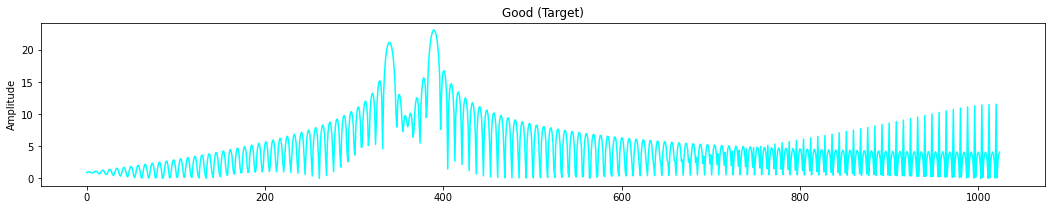

In [9]:
i = np.random.randint(len(dataset))

plot_signal(dataset[i][0])
f_s = fft(dataset[i][0])
plot_signal(abs(f_s), db = True, title = "Bad (Input)")

f_s = dataset[i][1]
plot_signal(abs(f_s), db = True, title = "Good (Target)")


#### Mission 3: Somehow model the problem into a neural network.

In [10]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.fc1 = nn.Linear(in_features=N_max, out_features=2**11)
        self.fc2 = nn.Linear(in_features=2**11, out_features=2**8)
        self.fc3 = nn.Linear(in_features=2**8, out_features=1025)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of your neural network
my_net = model().to(device)

In [11]:
def plotTrain(model, sampled):
    my_net.eval()
    fig, axs = plt.subplots(nrows=len(sampled)//2, ncols=2, figsize=(15,8))
    for i, idx in enumerate(sampled):
        x, y = test_dataset[idx]
        row = i // 2
        col = i % 2
        axs[row, col].plot(y, label="target")
        axs[row, col].plot(my_net(x.float()).detach().numpy(), label = "output")
        axs[row, col].plot(fft(x), label = "bad")
    
    plt.tight_layout()
    plt.show()
    my_net.train()
    
num_samples = 8
indices = list(range(len(test_dataset)))
sampled_indices = np.random.choice(indices, num_samples, replace=False)

Epoch 200 - Train Loss: 336.3487, Test Loss: 397.9378


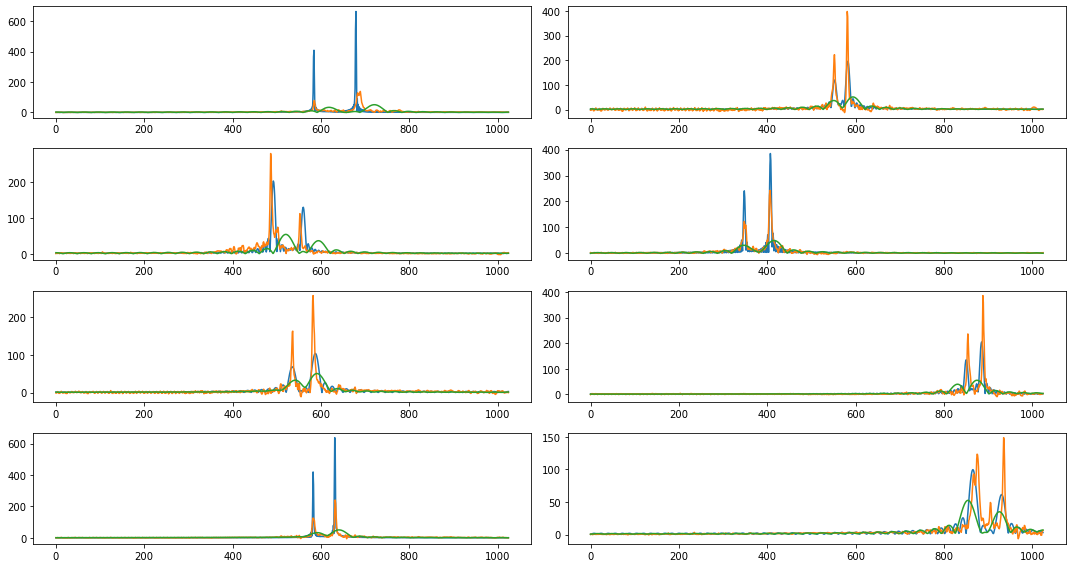

In [12]:
# Define your loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(my_net.parameters(), lr=0.01, weight_decay=1e-5)

best_model = None
best_loss = np.inf

train_losses = []
test_losses = []

# Train the neural network
for epoch in range(200):
    my_net.train()
    train_loss = 0.0
    for x,y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = my_net(x.float())
        loss = criterion(outputs, y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_dataset)
    
    my_net.eval()
    test_loss = 0.0
    for x,y in test_loader:
        x = x.to(device)
        y = y.to(device)
        outputs = my_net(x.float())
        loss = criterion(outputs, y.float())
        test_loss += loss.item() * x.size(0)
    test_loss /= len(test_dataset)
    clear_output(wait = True)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = copy.deepcopy(my_net)
    
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    plotTrain(my_net, sampled_indices)

    # Set the network back to training mode
    my_net.train()

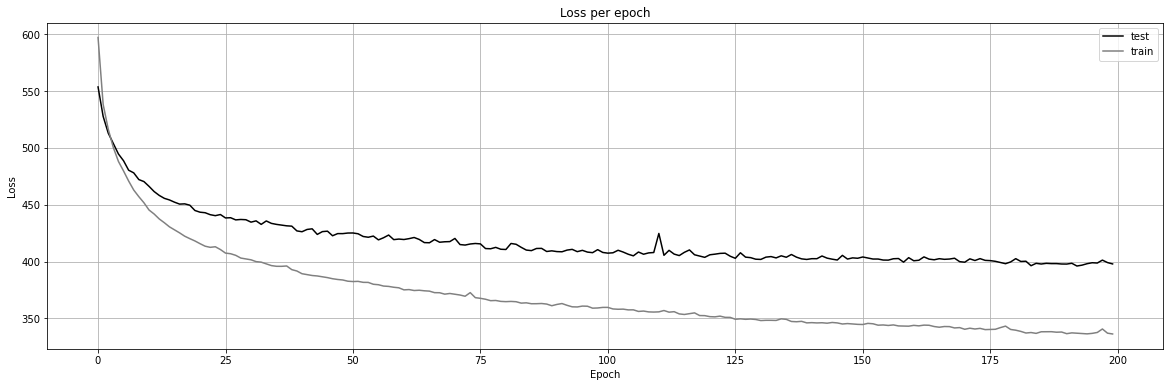

In [13]:
fig = plt.figure()

plt.title("Loss per epoch")

plt.plot(test_losses, label = "test", color = "black")
plt.plot(train_losses, label = "train", color = "gray")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

fig.set_size_inches(20, 6)

plt.grid()
plt.show()

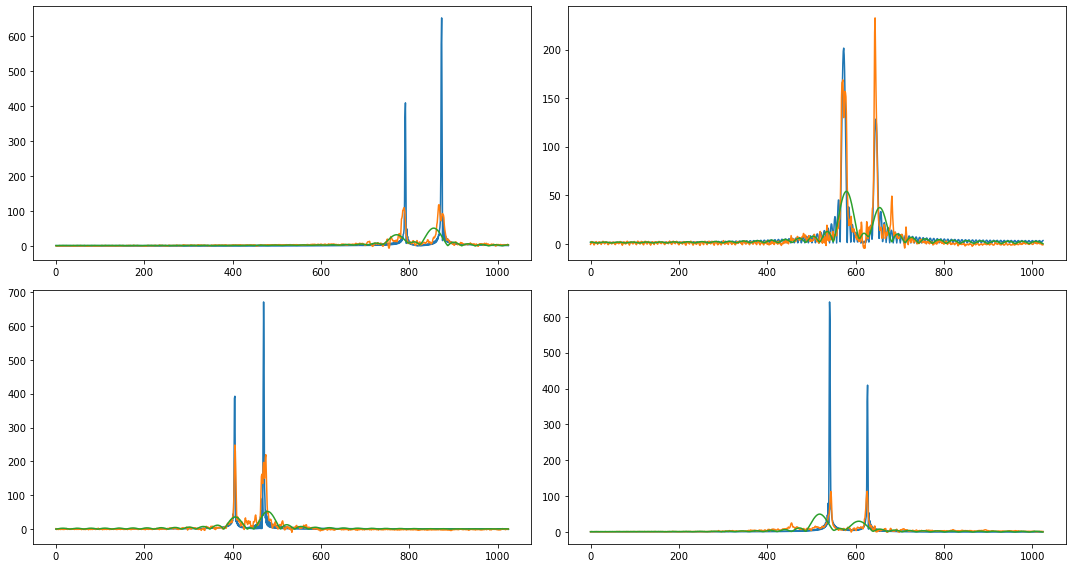

In [14]:
for i in range(10):

    clear_output(wait = True)
    num_samples = 4
    indices = list(range(len(test_dataset)))
    sampled_indices = np.random.choice(indices, num_samples, replace=False)

    plotTrain(best_model, sampled_indices)
    
    time.sleep(4)

In [15]:
torch.save({
    'model': best_model,
    'optimizer': optimizer,
    'epoch': 200
}, 'model.pt')